# Project 1: predicting the value of C6H6(GT)

Let's first get data imported.

In [ ]:
import pandas as pd
import os
import numpy as np
airquality_data = pd.read_csv("AirQualityUCI.csv", sep = ";")
airquality_data.head ()

FileNotFoundError: [Errno 2] No such file or directory: 'AirQualityUCI.csv'

In [ ]:
!pip install ucimlrepo
import ucimlrepo as uci

In [ ]:
air_quality = uci.fetch_ucirepo(id=360)
air_quality.data.features
airquality_data = air_quality.data.features
airquality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


Now let's do some data cleaning with this data set. First we wanted to change the column name by removing the parenthesis and add a underline in between.

In [ ]:
airquality_data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

There are two additional columns that do not hold any data, need to delete both of them as well.

In [ ]:
airquality_data = airquality_data.iloc [:,0:15]
airquality_data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [ ]:
airquality_data.columns = airquality_data.columns.str.replace("(", "_").str.replace(")", "")
airquality_data.columns

Index(['Date', 'Time', 'CO_GT', 'PT08.S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08.S2_NMHC', 'NOx_GT', 'PT08.S3_NOx', 'NO2_GT', 'PT08.S4_NO2',
       'PT08.S5_O3', 'T', 'RH', 'AH'],
      dtype='object')

This data set has some missing values on the column "C6H6(GT)" and "CO(GT)" that are represented by the value "-200" in the data frame. Let's ignore those data.

In [ ]:
airquality_data = airquality_data.loc [airquality_data["C6H6_GT"] != -200]
airquality_data = airquality_data.loc [airquality_data["CO_GT"] != -200]

Now we are ready to predict the true measurement of C6H6 using the data set, based on two different hypothesis:

1) The prediction is just one constant value that is going to minimize the loss function:

\sqrt{(1/n*sum [(yi-c)^2])}

2) The prediction is a simple linear regression of the value of the measurement 'PT08.S1_CO' that minimizes the loss function.

There are basically three different approach to this: calculus, grid search algorithm and gradient descent algorithm. Let's start with the grid search algorithm and create a grid of search.

## Grid search algorithm



### Prediction as a constant

In [ ]:
airquality_data ['C6H6_GT'].quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])

,C6H6_GT
0.05,1.8
0.25,4.6
0.50,8.5
0.75,14.3
0.95,24.6


A reasonable range to look at for grid search may be from the first quarter to the third quarter, that is [4.6, 14.3].

In [ ]:
import numpy as np
grid_c = np.linspace(4.6, 14.3, 10)
print (grid_c)

[ 4.6         5.67777778  6.75555556  7.83333333  8.91111111  9.98888889
 11.06666667 12.14444444 13.22222222 14.3       ]


In order to help with calculation, we set up the true value of y (concentration of C6H6) in an np array instead of in pandas series.

In [ ]:
y_true = np.array(airquality_data['C6H6_GT'])
y_true

array([11.9,  9.4,  9. , ..., 12.4,  9.5, 11.9])

Then we could generate the root mean squared error function that essentially square roots the mean of iterate sum of the squared loss function.


In [ ]:
def compute_rmse (y, c):
    """
    Calculate RMSE between true values and prediction values.
    Parameters:
    - y: array-like, true values
    - c: array-like, prediction values
    Returns:
    - RMSE (float)
    """
    squared_loss = 0
    for i in y:
        squared_loss += (i-c)**2
    return np.sqrt(squared_loss/len(y))

Let's try if this function works.

In [ ]:
c = [5]
print (compute_rmse(y_true, c))

[9.12114753]


It works! Now let's do a comprehensive to loop over the grid of c values, that is grid_c

In [ ]:
rmse_values = [compute_rmse(y_true, c) for c in grid_c]
print ("For constant c", grid_c,
       "we have rmse values", rmse_values)
print ("The minimum rmse value is", min(rmse_values))

For constant c [ 4.6         5.67777778  6.75555556  7.83333333  8.91111111  9.98888889
 11.06666667 12.14444444 13.22222222 14.3       ] we have rmse values [9.358200707363698, 8.74660863835101, 8.231258393598928, 7.831173391545652, 7.564664467856872, 7.446088248913168, 7.482480991388598, 7.671637585217715, 8.002732943682478, 8.45911672536917]
The minimum rmse value is 7.446088248913168


That is our prediction using the constant approach. When c gets the value at 9.989, the rmse reaches the smallest value at 7.446. Just to be cautious our grid might be too loose, we increase the number of c in the array to 20 to see if the rmse improves significantly. Otherwise it may not worth the computing power.

In [ ]:
grid_c_2 = np.linspace(4.6, 14.3, 20)
rmse_values_2 = [compute_rmse(y_true, c) for c in grid_c_2]
print ("For constant c", grid_c_2,
       "we have rmse values", rmse_values_2)
print ("The minimum rmse value is", min(rmse_values_2))

For constant c [ 4.6         5.11052632  5.62105263  6.13157895  6.64210526  7.15263158
  7.66315789  8.17368421  8.68421053  9.19473684  9.70526316 10.21578947
 10.72631579 11.23684211 11.74736842 12.25789474 12.76842105 13.27894737
 13.78947368 14.3       ] we have rmse values [9.358200707363698, 9.057667091487305, 8.77656083208839, 8.51680580832463, 8.280411617323356, 8.06943158878743, 7.885905782988109, 7.731789450601803, 7.608869852805753, 7.51867721103009, 7.462398261190379, 7.440802567720617, 7.454191581466467, 7.502377999863793, 7.584698636775368, 7.70005879242442, 7.847001442660025, 8.023791629501085, 8.228505746757566, 8.45911672536917]
The minimum rmse value is 7.440802567720617


The rmse value improved from 7.446 to 7.441, this is not impressive so maybe 10-point grid for c is good enough for this purpose. This prediction condition is better viewed as below in the charts.

<Axes: xlabel='c', ylabel='rmse'>

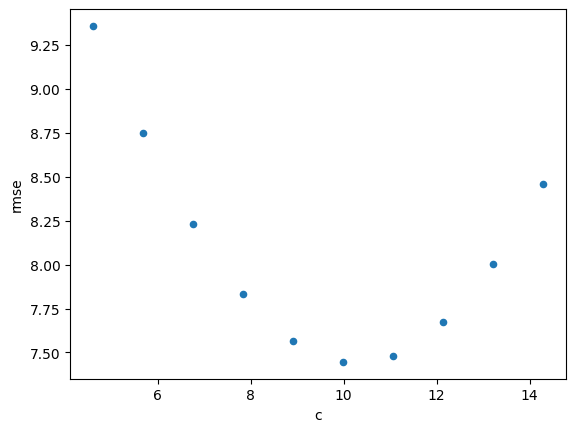

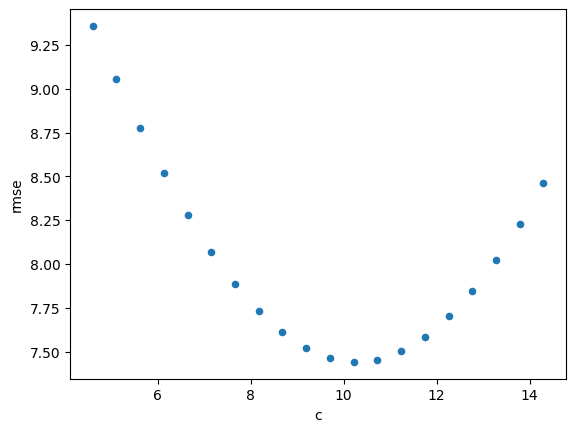

In [ ]:
pred_table = zip (grid_c, rmse_values)
pred_table = pd.DataFrame(pred_table, columns = ['c', 'rmse'])
pred_table.plot(x = 'c', y = 'rmse', kind = 'scatter')
pred_table_2 = zip (grid_c_2, rmse_values_2)
pred_table_2 = pd.DataFrame(pred_table_2, columns = ['c', 'rmse'])
pred_table_2.plot(x = 'c', y = 'rmse', kind = 'scatter')

Now let's see if our algorithm generalizes, let's use the variable: PT08.S1_CO as the response.

In [ ]:
y_true_test = np.array(airquality_data['PT08.S1_CO'])
rmse_values_test = [compute_rmse(y_true_test, c) for c in grid_c]
print ("For constant c", grid_c,
       "we have rmse values", rmse_values)
print ("The minimum rmse value is", min(rmse_values))


For constant c [ 4.6         5.67777778  6.75555556  7.83333333  8.91111111  9.98888889
 11.06666667 12.14444444 13.22222222 14.3       ] we have rmse values [9.358200707363698, 8.74660863835101, 8.231258393598928, 7.831173391545652, 7.564664467856872, 7.446088248913168, 7.482480991388598, 7.671637585217715, 8.002732943682478, 8.45911672536917]
The minimum rmse value is 7.446088248913168


Now let's look at the condition where we take PT08.S1_CO as our x variable and C6H6_GT as our y variable.

### Prediction as Simple linear regression of one predictor

Another way, which may be a better way to predict the true value of C6H6, is to use simple linear regression of other predicotors that are readily avaiable in our data set. To simplify things we would just use the measurement PT08.S1_CO as the singular variable to predict C6H6_GT using the algorithm below:

y = b0 + b1*x

Where y is the true value of C6H6 as in the pandaseries C6H6_GT and also in our previously set up nparray: y_true, x is the measurement of CO by the sensor, which is reflected in the pandaseries PT08.S1_CO, which is better to turn it also into a np array. For the unknow parameter b0 and b1, let's set up the grid to make it two dimensional.

In [ ]:
b0 = np.arange(-30, -10, 0.1)
b1 = np.arange(-100, 100, 0.01)
B0, B1 = np.meshgrid(b0, b1)

Here we used iterative coding to vertually get every combination of b1 and b0 (totally 2,500) though it's a scaled back data set due to speed issue, and generates the prediction pred_slr based on each of the combination.

Remember, for each of the 2,500 combinations, there are still 7344 different y numbers based on the b0/b1 combinations.

With the true value and predicted value in each condition, we could proceed to calculate the rmse. This is to sum up all the 7344 different prediction and true pairs and to generate 2,500 differnt rmse values.

Let's first write a function to take in two arrays and calculate the rmse, and then write a procedure to guide through the grid.


In [ ]:
def compute_rmse_2 (a, b):
    """
    Calculate RMSE between true values and simulated values.

    Parameters:
    - y: array-like, true values
    - y_pred: array-like, predicted/simulated values

    Returns:
    - RMSE (float)
    """
    squared_loss = np.sum((a - b) ** 2)
    rmse = np.sqrt(squared_loss/len(a))
    return rmse

In [ ]:
print (len (y_true))

7344


Then we could integrate it in the grid search via a loop

In [ ]:
rmse_slr_results = []

for i in range(len(b1)):
    for j in range(len(b0)):
        b0_value = B0[i, j]
        b1_value = B1[i, j]
        pred_slr = b0_value + b1_value * airquality_data['PT08.S1_CO']
        rmse_slr = compute_rmse_2 (y_true, pred_slr)
        rmse_slr_results.append((b0_value, b1_value, airquality_data ["PT08.S1_CO"], pred_slr, rmse_slr))
rmse_slr_df = pd.DataFrame(rmse_slr_results, columns=['b0', 'b1', 'x', 'y', 'RMSE'])
rmse_slr_df.head()

In [ ]:
# 변수 초기화
min_rmse = float('inf')  # 초기 최소 RMSE 값
best_b0, best_b1 = None, None  # 최적 b0, b1 값

# 벡터화된 연산을 사용한 RMSE 계산
for i in range(len(b1)):
    for j in range(len(b0)):
        b0_value = B0[i, j]
        b1_value = B1[i, j]

        # 예측값 계산 (벡터화된 방식)
        pred_slr = b0_value + b1_value * airquality_data['PT08.S1_CO'].values

        # RMSE 계산
        rmse_slr = compute_rmse_2(y_true, pred_slr)  # compute_rmse_2 정의 확인 필요

        # 최소 RMSE 값 추적
        if rmse_slr < min_rmse:
            min_rmse = rmse_slr
            best_b0, best_b1 = b0_value, b1_value

# 최적 결과 출력
print(f"The minimum RMSE is {min_rmse} at b0 = {best_b0} and b1 = {best_b1}")

The minimum RMSE is 3.542905391554358 at b0 = -22.9999999999999 and b1 = 0.030000000051174425


In [ ]:
# 특정 PT08.S1(CO) 값에 해당하는 C6H6(GT)의 참값 추출
actual_y_values = airquality_data.loc[
    airquality_data['PT08.S1_CO'].isin([946, 1075, 1246]), 'C6H6_GT'
]

# 예측할 PT08.S1(CO) 값 리스트
new_x_values = np.array([946, 1075, 1246])

# 최적의 b0, b1을 사용하여 C6H6(GT) 예측
predicted_y_values = best_b0 + best_b1 * new_x_values

# 결과 출력
print("Comparison of Actual and Predicted C6H6(GT) values:")
for x, actual_y, predicted_y in zip(new_x_values, actual_y_values, predicted_y_values):
    print(f"PT08.S1(CO) = {x} | Actual C6H6(GT) = {actual_y:.4f} | Predicted C6H6(GT) = {predicted_y:.4f}")


Comparison of Actual and Predicted C6H6(GT) values:
PT08.S1(CO) = 946 | Actual C6H6(GT) = 3.9000 | Predicted C6H6(GT) = 5.3800
PT08.S1(CO) = 1075 | Actual C6H6(GT) = 2.9000 | Predicted C6H6(GT) = 9.2500
PT08.S1(CO) = 1246 | Actual C6H6(GT) = 5.4000 | Predicted C6H6(GT) = 14.3800


Now we want to see the best combination with the smallest RMSE:

In [ ]:
rmse_slr_df['RMSE'].min()

190.25742458113766

In [ ]:
best_combination = rmse_slr_df.loc[rmse_slr_df['RMSE'].idxmin()]
print(f"Best combination of b0, b1: {best_combination}")

Best combination of b0, b1: b0                                                  -30.0
b1                                               0.204082
x       0       1360
1       1292
2       1402
3      ...
y       0       247.551020
1       233.673469
2       ...
RMSE                                           190.257425
Name: 1250, dtype: object


So when predction y = -30+2.041x, smallest RMSE was obtained. But this is much higher than the value we obtained earlier using the constant value method. Is there anything wrong with the previous method? Use the previous function to calculate the slr rmse

In [ ]:
print(airquality_data[['PT08.S1_CO', 'C6H6_GT']].corr())


            PT08.S1_CO   C6H6_GT
PT08.S1_CO    1.000000  0.879379
C6H6_GT       0.879379  1.000000


The correlation between the PT08.S1_CO (x) and C6H6_GT was quite strong, so x should be a good predictor of y. Let's draw a simple dot plot with a regression line with x = PT08.S1_CO and y = C6H6_GT.

<Axes: title={'center': 'CO vs C6H6'}, xlabel='PT08.S1_CO', ylabel='C6H6_GT'>

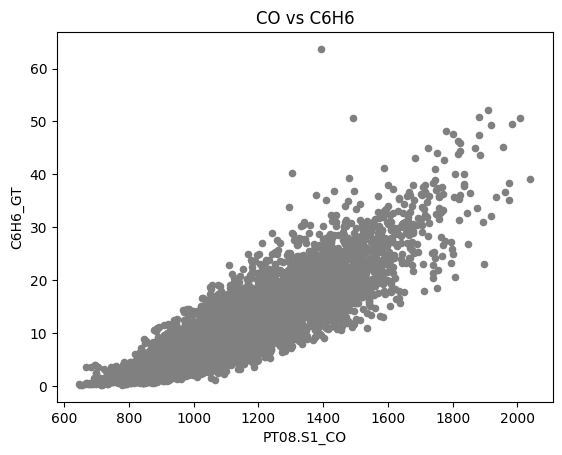

In [ ]:
airquality_data.plot.scatter(x = "PT08.S1_CO", y = "C6H6_GT", c = "Gray", title = "CO vs C6H6")


The slope of the regression line by eye is more likely to be around 60/1400 to 40/1400, which is between 0.0286 to 0.0429. We could re-set the range of B0 and B1 again to narrow down the search.

In [ ]:
b0 = np.linspace(-30, -10, 50)
b1_2 = np.linspace(0.02, 0.05, 50)
B0, B1_2 = np.meshgrid(b0, b1_2)

In [ ]:
rmse_slr_results_2 = []

for i in range(len(b1_2)):
    for j in range(len(b0)):
        b0_value = B0[i, j]
        b1_value_2 = B1_2[i, j]
        pred_slr_2 = b0_value + b1_value_2 * airquality_data['PT08.S1_CO']
        rmse_slr_2 = compute_rmse_2 (y_true, pred_slr_2)
        rmse_slr_results_2.append((b0_value, b1_value_2, airquality_data ["PT08.S1_CO"], pred_slr_2, rmse_slr_2))
rmse_slr_df_2 = pd.DataFrame(rmse_slr_results_2, columns=['b0', 'b1', 'x', 'y', 'RMSE'])
print(rmse_slr_df_2.head())

          b0    b1                                                  x  \
0 -30.000000  0.02  0       1360
1       1292
2       1402
3      ...   
1 -29.591837  0.02  0       1360
1       1292
2       1402
3      ...   
2 -29.183673  0.02  0       1360
1       1292
2       1402
3      ...   
3 -28.775510  0.02  0       1360
1       1292
2       1402
3      ...   
4 -28.367347  0.02  0       1360
1       1292
2       1402
3      ...   

                                                   y       RMSE  
0  0      -2.80
1      -4.16
2      -1.96
3      ...  18.535652  
1  0      -2.391837
1      -3.751837
2      -1.55...  18.138103  
2  0      -1.983673
1      -3.343673
2      -1.14...  17.741035  
3  0      -1.57551
1      -2.93551
2      -0.7355...  17.344483  
4  0      -1.167347
1      -2.527347
2      -0.32...  16.948482  


In [ ]:
rmse_slr_df_2['RMSE'].min()

3.5443027993792295

In [ ]:
best_combination_2 = rmse_slr_df_2.loc[rmse_slr_df_2['RMSE'].idxmin()]
print(f"Best combination of b0, b1: {best_combination_2}")

Best combination of b0, b1: b0                                             -23.469388
b1                                               0.030408
x       0       1360
1       1292
2       1402
3      ...
y       0       17.885714
1       15.817959
2       19...
RMSE                                             3.544303
Name: 866, dtype: object


This is successful. We were able to reduce to value of RMSE from 7.441 in the constant c approach to 3.544 in the SLR approach, and the model is y = -23.47+0.0304*x.

## Gradient Descent Algorithm

Previously we explored the use of grid search algorithm. This is like a brutal force approach which calculates every possibility in the grid. Powerful and comprehensive as it may be, it requires tremendous amount of computing power, even it is just from the simple linear regression, and could cause hours if not days to compute, probably requiring a supercomputer access if dealing with more complex regression methods.

Now we would like to explore a more elegant approach -- gradient descent approach.

Starting from the single constant c method. As shown in the figure above, RMSE reaches the minimum point in the middle of the range of constant c. So if the value of c you guessed is smaller than the true value of c, the slope of the RMSE vs c will be negative. On the contrary, if the value of c being guessed is bigger than the true value, the slope of RMSE vs c will be positive. When the guessed value c is very close or at the true value c, the slope around there will be close to 0. We could use this property to **gradiently** **descent** to the true value of c.

 Let's first make a function to calculate the RMSE. In fact, this is the same with before.

In [ ]:
help (compute_rmse)

Help on function compute_rmse in module __main__:

compute_rmse(y, c)
    Calculate RMSE between true values and prediction values.
    Parameters:
    - y: array-like, true values
    - c: array-like, prediction values
    Returns:
    - RMSE (float)



Now let's make a function to calcuate the slope of RMSE. Technically it would be hard to get the exact slope of RMSE at the point of guessed value of c, but we could select another point very close to c, let's say c+d, in which d is a very small value. Then the slope of RMSE at c could be estimated by (RMSE (y,c) - RMSE (y,c+d))/d

In [ ]:
def diff_quotient (y,c,d=0.0001):
    RMSE_c = compute_rmse(y,c)
    RMSE_c_d = compute_rmse(y,c+d)
    return (RMSE_c_d - RMSE_c)/d
